Case study: If you are a Datascience (AI /ML) sales person for a company, what solution will you sell to a school management committee? Why and how?Create a prototype of the solution assuming the committee has approved your proposal and given you any data you require for them.

The solution is basically a student performance prediction and intervention system which helps to identify academically poor students and improve their performance.

Based on previous 1 year marks scored in Quareterly test and annual exam and attendance and homework submission, we can segregate the students who performs well in their academics and who are not, based on that teacher can focus more on the students who are poor in their academics and improve their performance this leads to better exam results and school gets good reputation and gets more number of admissions.

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation


### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [1]:
#importing required libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve,roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

 Generated synthetic dataset using python faker library

In [2]:
# Loading the students data
df = pd.read_csv(r'd:/skillslash/machine_learning/students_data.csv')

In [3]:
# summary of the dataset: 1005 rows, 7 columns, no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Student_ID             1005 non-null   object 
 1   Name                   1005 non-null   object 
 2   Monthly_Avg_Score      950 non-null    float64
 3   Attendance_Percentage  950 non-null    float64
 4   Homework_Completed     1005 non-null   int64  
 5   Annual_Exam_Score      950 non-null    float64
 6   Target_Score           1005 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 55.1+ KB


In [4]:
df.head()

,Student_ID,Name,Monthly_Avg_Score,Attendance_Percentage,Homework_Completed,Annual_Exam_Score,Target_Score
0,STU5838,Grace Wolfe,73.48,84.31,80,77.11,80.304086
1,STU7082,Lisa Leonard,63.58,84.38,80,68.42,73.097658
2,STU7746,Alexander Kim,65.93,82.37,90,75.83,78.169609
3,STU5466,Bailey Mcgee,52.93,88.02,97,61.73,65.897179
4,STU9011,Charlotte Perez,71.00,84.83,94,75.17,76.493015


In [5]:
# Rename column for easier reference
df.rename(columns={'Annual_Exam_Score': 'Annual_marks_previous', 'Monthly_Avg_Score':'Quarterly_Avg_Score'},inplace=True)

In [6]:
df.columns

Index(['Student_ID', 'Name', 'Quarterly_Avg_Score', 'Attendance_Percentage',
       'Homework_Completed', 'Annual_marks_previous', 'Target_Score'],
      dtype='object')

#Create Target Variable

In [7]:
#Redefining the  target variable
df['Performance'] = df['Target_Score'].apply(lambda x: 'Good' if x >= 70 else 'Poor')
df['Performance_numeric'] = df['Performance'].map({'Poor': 0, 'Good': 1})

# Drop Target_Score if not needed
df.drop(columns='Target_Score', inplace=True)

# checking the class distribution
print("Class distribution:")
#print(df['Performance'].value_counts(normalize=True))
print(df['Performance'].value_counts())


Class distribution:
Performance
Good    854
Poor    151
Name: count, dtype: int64


In [8]:
#after redefining the target column once again checking column names
df.columns

Index(['Student_ID', 'Name', 'Quarterly_Avg_Score', 'Attendance_Percentage',
       'Homework_Completed', 'Annual_marks_previous', 'Performance',
       'Performance_numeric'],
      dtype='object')

In [9]:
df.head()

,Student_ID,Name,Quarterly_Avg_Score,Attendance_Percentage,Homework_Completed,Annual_marks_previous,Performance,Performance_numeric
0,STU5838,Grace Wolfe,73.48,84.31,80,77.11,Good,1
1,STU7082,Lisa Leonard,63.58,84.38,80,68.42,Good,1
2,STU7746,Alexander Kim,65.93,82.37,90,75.83,Good,1
3,STU5466,Bailey Mcgee,52.93,88.02,97,61.73,Poor,0
4,STU9011,Charlotte Perez,71.00,84.83,94,75.17,Good,1


In [10]:
#checking statistics of the dataset
df.describe()

,Quarterly_Avg_Score,Attendance_Percentage,Homework_Completed,Annual_marks_previous,Performance_numeric
count,950.000000,950.000000,1005.000000,950.000000,1005.000000
mean,70.357589,84.962568,85.635821,73.349800,0.849751
std,9.179003,6.196204,8.971886,7.036406,0.357493
min,5.000000,-10.000000,70.000000,52.740000,0.000000
25%,65.442500,81.832500,78.000000,68.840000,1.000000
50%,70.290000,85.320000,86.000000,73.590000,1.000000
75%,75.307500,88.242500,93.000000,78.052500,1.000000
max,200.000000,150.000000,100.000000,94.560000,1.000000


4.309927462508641


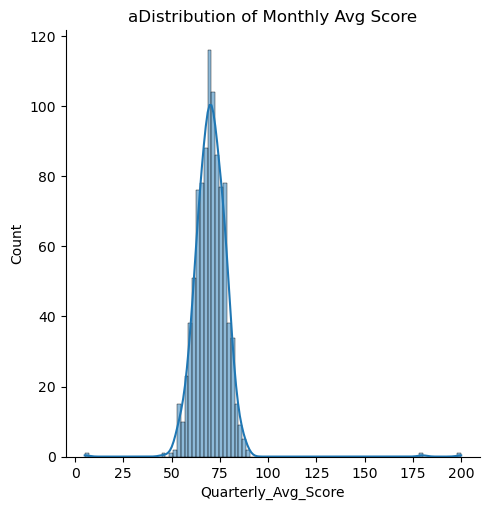

In [11]:
#This is stronglypostively skewed,most of student scored around 70, the scores are tightly clusted between around 60-80, 
#and few outliers are present
print(df['Quarterly_Avg_Score'].skew())
sns.displot(df['Quarterly_Avg_Score'], kde=True)
plt.title('aDistribution of Monthly Avg Score')
plt.show()

-0.15590930334386532


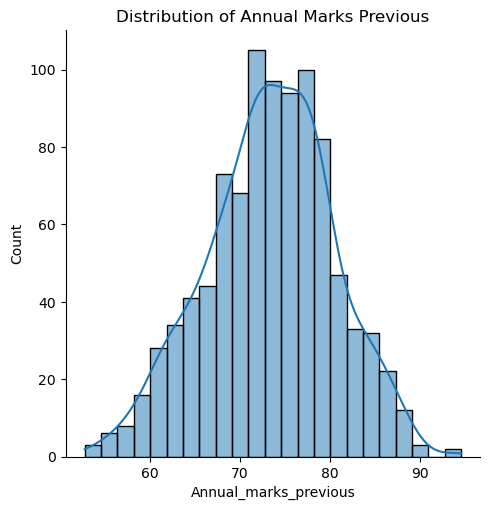

In [12]:
#This is slightly negatively skewed, but very close to zero,we can say distribution is symmetric,
#most of student scored around 74, the scores are clusted between around 70-80, and there are no outliers present
print(df['Annual_marks_previous'].skew())
sns.displot(df['Annual_marks_previous'], kde=True)
plt.title('Distribution of Annual Marks Previous')
plt.show()

-2.6636439457839627


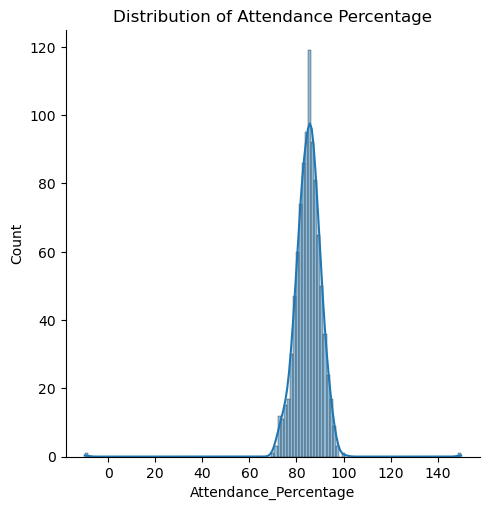

In [13]:
#This is strongly negativey skewed and most of the attandence score around 85% with a values tightly clustred between 
#around 79% - 90%. and exterem outliers are present at -ve side likely due to poor attadance 
print(df['Attendance_Percentage'].skew()) 
sns.displot(df['Attendance_Percentage'], kde=True)
plt.title('Distribution of Attendance Percentage')
plt.show()


-0.11482052133168898


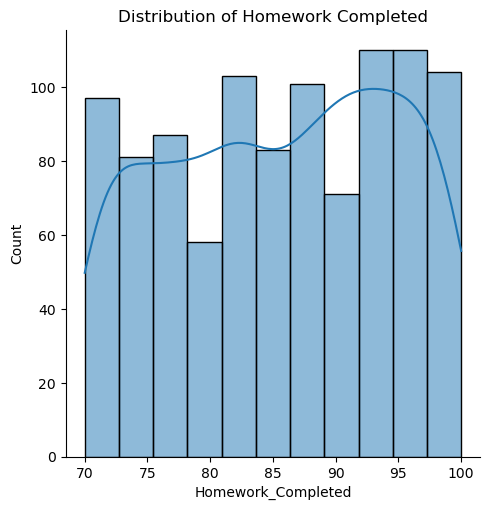

In [14]:
#Since skewwness is very close to 0, the distribution is symmetric, the scores are clustred between 70% to 100%, no outliers are present
print(df['Homework_Completed'].skew())
sns.displot(df['Homework_Completed'], kde=True)
plt.title('Distribution of Homework Completed')
plt.show()


In [15]:
# Print correlation matrix
df.corr(numeric_only=True)['Performance_numeric'].sort_values(ascending=False)

Performance_numeric      1.000000
Annual_marks_previous    0.587305
Quarterly_Avg_Score      0.428660
Homework_Completed       0.177320
Attendance_Percentage    0.067877
Name: Performance_numeric, dtype: float64

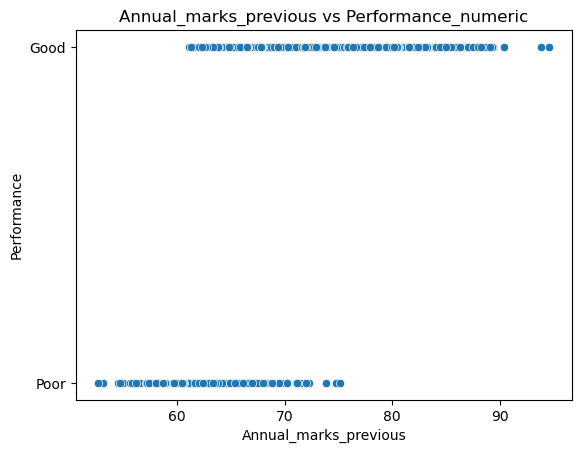

In [16]:
# Scatter plot between Annual_marks_previous and performance
sns.scatterplot(x=df['Annual_marks_previous'], y=df['Performance'])
plt.title('Annual_marks_previous vs Performance_numeric')
plt.show()


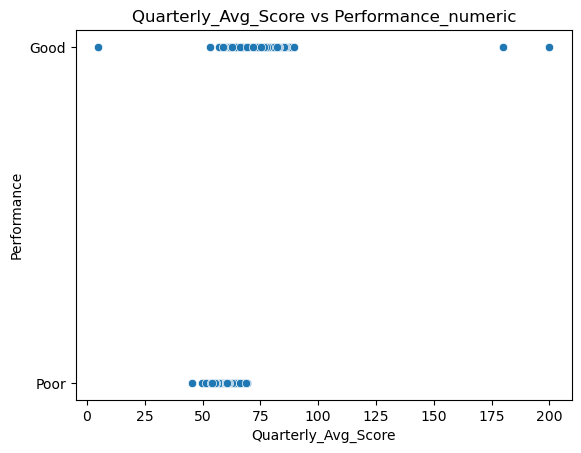

In [17]:
# Scatter plot between Quarterly_Avg_Score and performance
sns.scatterplot(x=df['Quarterly_Avg_Score'], y=df['Performance'])
plt.title('Quarterly_Avg_Score vs Performance_numeric')
plt.show()

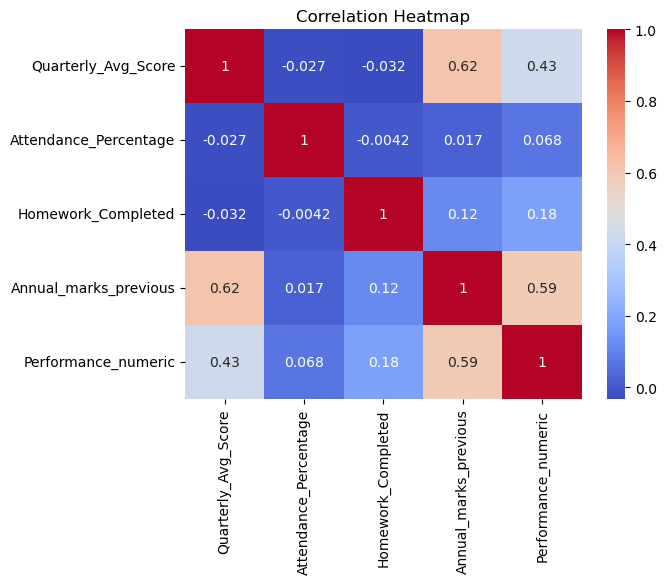

In [18]:
# Heatmap for correlation between numeric features
df_numeric = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [19]:
#checking correlated values of other features with respect to Target Feature Performace_numeric
df.corr(numeric_only=True)['Performance_numeric'].sort_values(ascending=False)


Performance_numeric      1.000000
Annual_marks_previous    0.587305
Quarterly_Avg_Score      0.428660
Homework_Completed       0.177320
Attendance_Percentage    0.067877
Name: Performance_numeric, dtype: float64

Data Cleaning

In [20]:
# Checking and removing duplicates
print("Duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()


Duplicate rows: 5


In [21]:
# Checking and filling missing values
print("Missing values:", df.isnull().sum())
for col in ['Quarterly_Avg_Score', 'Attendance_Percentage', 'Annual_marks_previous']:
    df[col] = df[col].fillna(df[col].median())

Missing values: Student_ID                0
Name                      0
Quarterly_Avg_Score      50
Attendance_Percentage    50
Homework_Completed        0
Annual_marks_previous    50
Performance               0
Performance_numeric       0
dtype: int64


In [22]:
#again checking for missing value
df.isnull().sum()

Student_ID               0
Name                     0
Quarterly_Avg_Score      0
Attendance_Percentage    0
Homework_Completed       0
Annual_marks_previous    0
Performance              0
Performance_numeric      0
dtype: int64

#Outlier detection

In [23]:
#Detetcting outliers for each column if exists
import numpy as np
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    print(f"Feature: {col}")
    print(f"Number of outliers detected: {outliers.shape[0]}")
    return outliers

# 3. Apply to your features
for col in ['Quarterly_Avg_Score','Attendance_Percentage', 'Annual_marks_previous', 'Homework_Completed']:
    detect_outliers_iqr(df, col)


Feature: Quarterly_Avg_Score
Number of outliers detected: 9
Feature: Attendance_Percentage
Number of outliers detected: 17
Feature: Annual_marks_previous
Number of outliers detected: 8
Feature: Homework_Completed
Number of outliers detected: 0


#capping

In [24]:
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

for col in ['Quarterly_Avg_Score','Attendance_Percentage', 'Annual_marks_previous', 'Homework_Completed']:
    df = cap_outliers_iqr(df, col)


Feature Engineering

In [25]:
#How much better or worse they did in the final annual exam compared to avg quarterly scpre
df['Improvement'] = df['Annual_marks_previous'] - df['Quarterly_Avg_Score']

6. Data Preprocessing

In [26]:
# Define features and target
X = df[['Quarterly_Avg_Score','Attendance_Percentage','Annual_marks_previous', 'Homework_Completed','Improvement']]
y = df['Performance_numeric']


In [27]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)


In [28]:
#smote to overcome imbalancee dataset problem
smote = SMOTE(k_neighbors=5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", Counter(y_train))
print("After SMOTE :", Counter(y_train_res))

Before SMOTE: Counter({1: 596, 0: 104})
After SMOTE : Counter({1: 596, 0: 596})


In [29]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [30]:
print(X_train_scaled.shape) 

(1192, 5)


7. model building

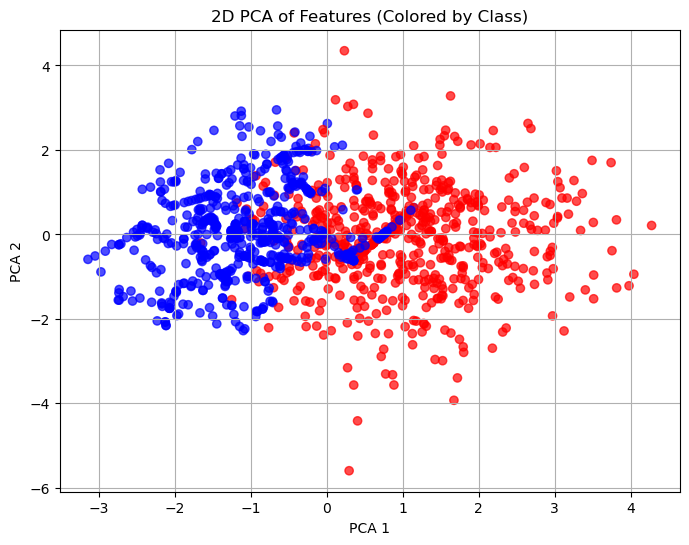

In [31]:
#to see whether data is linerly spread
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_res, cmap='bwr', alpha=0.7)
plt.title('2D PCA of Features (Colored by Class)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()


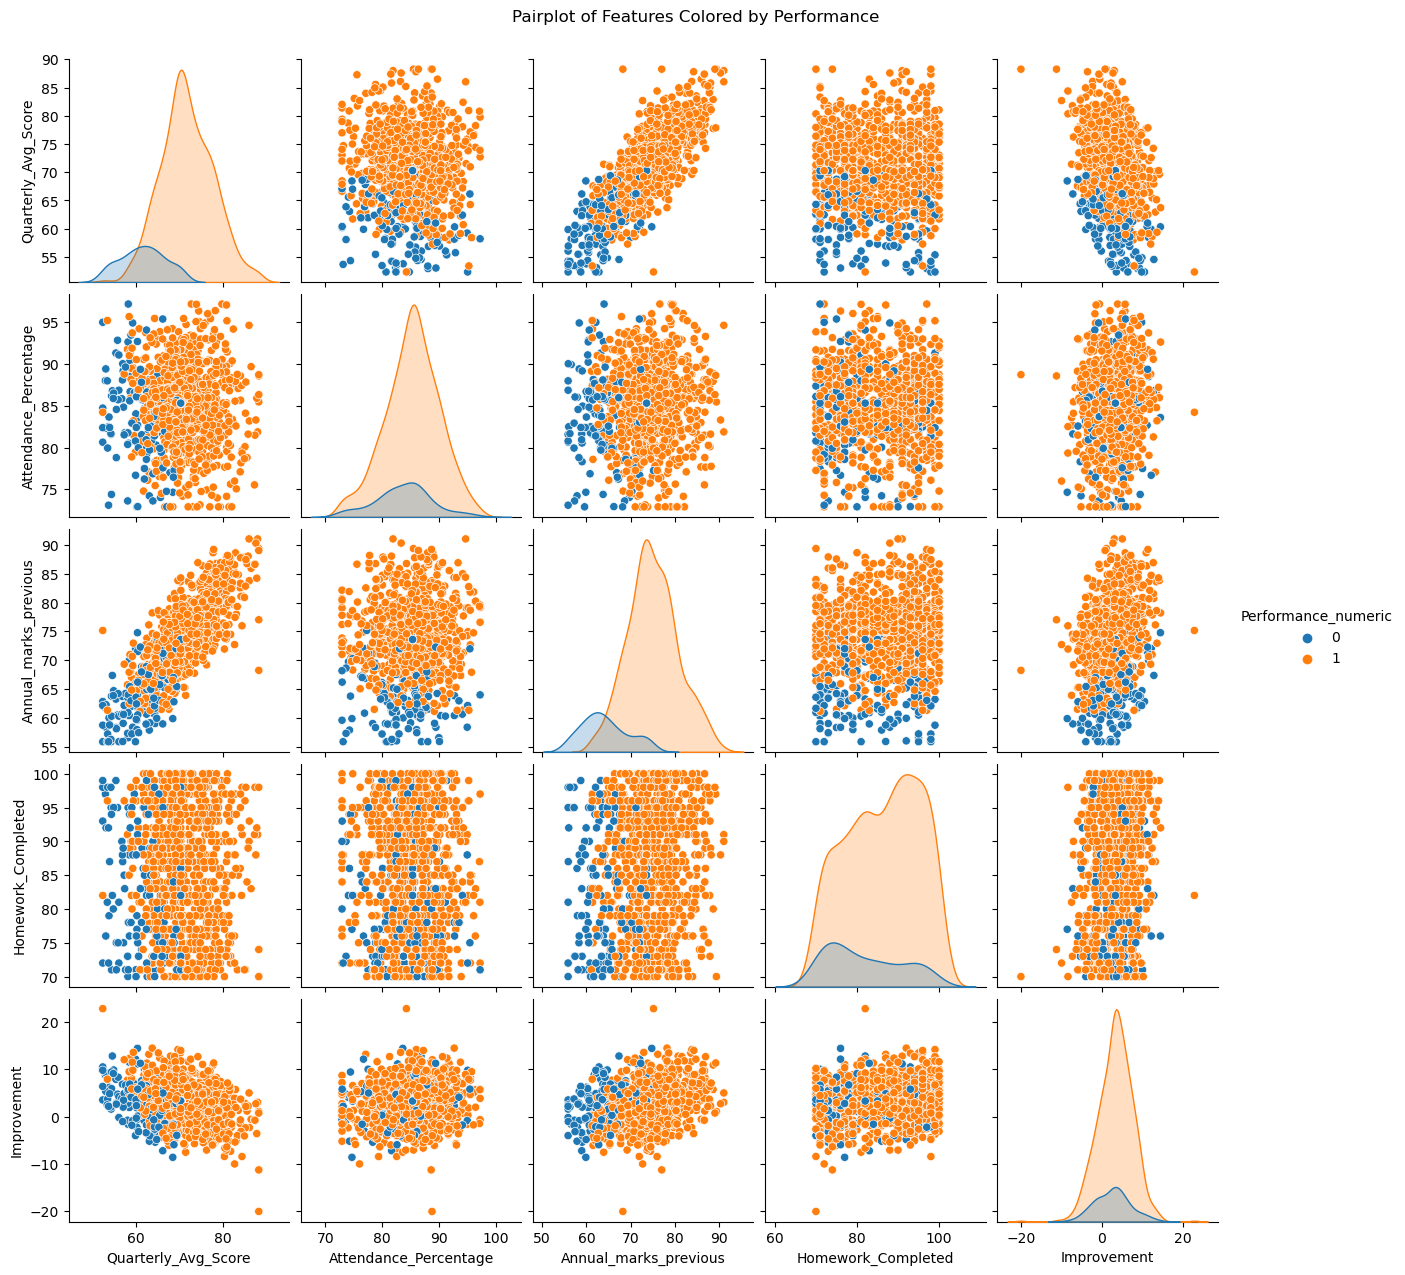

In [32]:
#to see whther 
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize all feature pairs-plot
sns.pairplot(df[['Quarterly_Avg_Score','Attendance_Percentage','Annual_marks_previous', 'Homework_Completed', 'Performance_numeric','Improvement']], 
             hue='Performance_numeric', diag_kind='kde')
plt.suptitle("Pairplot of Features Colored by Performance", y=1.02)
plt.show()


In [33]:
#Since the data is not linearlty spread, Logistic Regression is not a good choice, so not generated

              precision    recall  f1-score   support

           0       0.69      0.76      0.72        45
           1       0.96      0.94      0.95       255

    accuracy                           0.91       300
   macro avg       0.83      0.85      0.84       300
weighted avg       0.92      0.91      0.91       300

0.9133333333333333


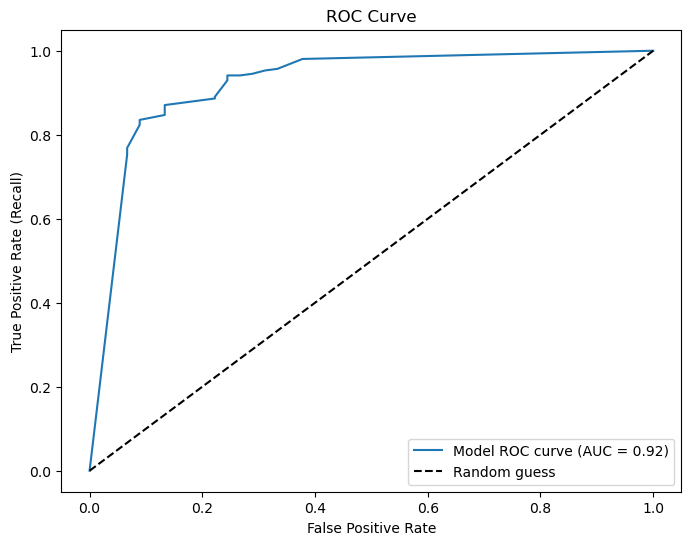

In [34]:
#Decision Tree Classifier
# Decision Tree hyperparameters
from sklearn.metrics import precision_score, recall_score, f1_score
dt_params = {
    'max_depth': [8,9,10],
    'min_samples_split': [16,18],
    'min_samples_leaf': [8,9,10],
    'criterion':['entropy'],
    'ccp_alpha': [0.001,0.01,0.1]
}
# Initialize Decision Tree with class_weight='balanced' to handle imbalance
dt = DecisionTreeClassifier(random_state=42,class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV to maximize recall
grid = GridSearchCV(dt, dt_params, scoring='balanced_accuracy', cv=cv)
grid.fit(X_train_res, y_train_res)

# Best model
best_dt = grid.best_estimator_

y_proba = best_dt.predict_proba(X_test)[:, 1]

y_pred_thresh = (y_proba >= 0.3).astype(int)

print(classification_report(y_test, y_pred_thresh))
print(accuracy_score(y_test, y_pred_thresh))

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [35]:
# Evaluate on training data
y_proba_train = best_dt.predict_proba(X_train_res)[:, 1]
y_pred_thresh_train = (y_proba_train >= 0.4).astype(int)

print("\n--- TRAIN SET PERFORMANCE ---")
print(classification_report(y_train_res, y_pred_thresh_train))

# Evaluate on test data
y_proba_test = best_dt.predict_proba(X_test)[:, 1]
y_pred_thresh_test = (y_proba_test >= 0.4).astype(int)

print("\n--- TEST SET PERFORMANCE ---")
print(classification_report(y_test, y_pred_thresh_test))



--- TRAIN SET PERFORMANCE ---
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       596
           1       0.89      0.97      0.93       596

    accuracy                           0.92      1192
   macro avg       0.93      0.92      0.92      1192
weighted avg       0.93      0.92      0.92      1192


--- TEST SET PERFORMANCE ---
              precision    recall  f1-score   support

           0       0.65      0.76      0.70        45
           1       0.96      0.93      0.94       255

    accuracy                           0.90       300
   macro avg       0.80      0.84      0.82       300
weighted avg       0.91      0.90      0.91       300



In [36]:
df['Performance_numeric'].value_counts()

Performance_numeric
1    851
0    149
Name: count, dtype: int64

Threshold used: 0.4
              precision    recall  f1-score   support

           0       0.72      0.73      0.73        45
           1       0.95      0.95      0.95       255

    accuracy                           0.92       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.92      0.92      0.92       300



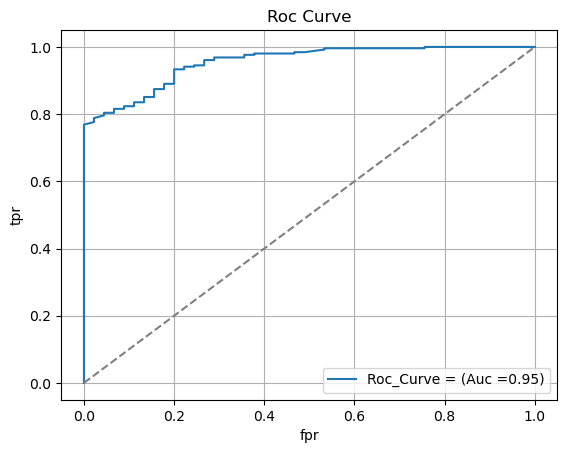

In [37]:
# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define hyperparameter grid
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
  }

# Grid Search with recall scoring
grid = GridSearchCV(estimator=rf,param_grid=rf_params,scoring='recall',cv=5)

# Fit model
grid.fit(X_train_res, y_train_res)

# Best model
best_rf = grid.best_estimator_

# Predict probabilities
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Threshold tuning
threshold = 0.4  # wwe can adjust this
y_pred_thresh = (y_proba >= threshold).astype(int)

# Classification report
print(f"Threshold used: {threshold}")
print(classification_report(y_test, y_pred_thresh))
fpr,tpr,threshold = roc_curve(y_test,y_proba)
auc = roc_auc_score(y_test,y_proba)
plt.plot(fpr,tpr,label = f'Roc_Curve = (Auc ={auc:.2f})')
plt.plot([0,1],[0,1],linestyle='--',color='gray')
plt.xlabel("fpr")
plt.ylabel('tpr')
plt.title("Roc Curve")
plt.legend()
plt.grid()
plt.show()


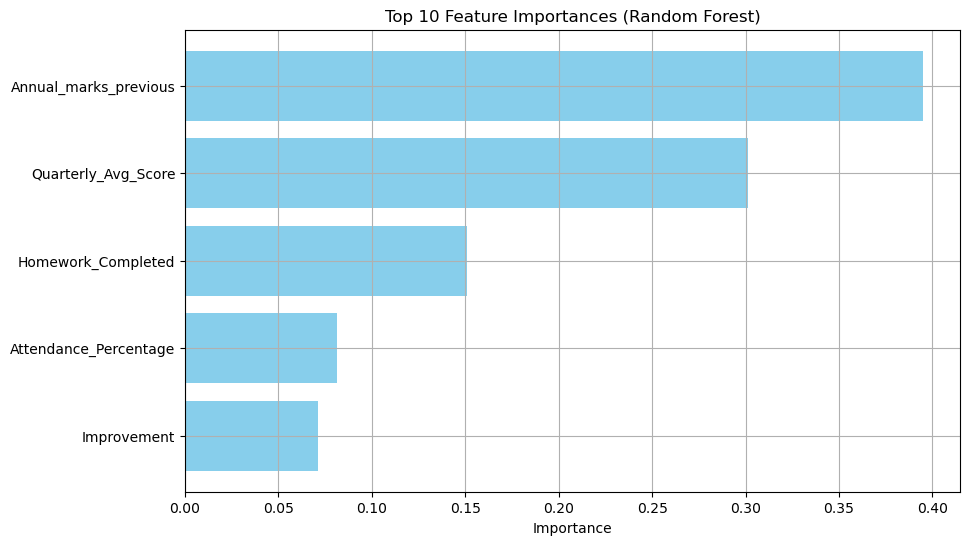

In [38]:
#To see which are the important Features
import pandas as pd
import matplotlib.pyplot as plt

# Assuming X_train is a DataFrame
importances = best_rf.feature_importances_
feature_names = X_train.columns

feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Top 10 features
plt.figure(figsize=(10,6))
plt.barh(feat_df['Feature'][:][::-1], feat_df['Importance'][:][::-1], color='skyblue')
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.grid(True)
plt.show()


0.174496644295302
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Threshold Tuned Report:
               precision    recall  f1-score   support

           0       0.60      0.82      0.69        45
           1       0.97      0.90      0.93       255

    accuracy                           0.89       300
   macro avg       0.78      0.86      0.81       300
weighted avg       0.91      0.89      0.90       300



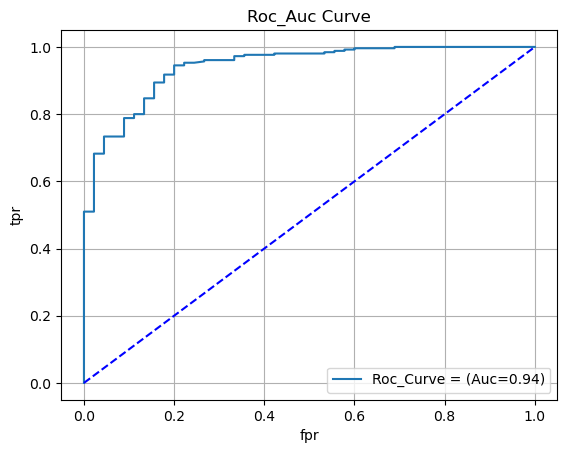

In [39]:
#Compute scale_pos_weight from training set
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]
print(scale_pos_weight)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_params = {
    'n_estimators': [200,250],
    'max_depth': [8,9],
    'learning_rate': [0.01,0.05,0.2],
    'subsample': [0.5,0.8,0.9,1.0],
    'colsample_bytree': [0.5,0.8,0.9,1.0],
    'scale_pos_weight': [scale_pos_weight], 
    'gamma' :[0.1,0.2,0.5]
}
#Cross-validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Grid Search
grid = GridSearchCV(estimator=xgb,
                    param_grid=xgb_params,
                    scoring='recall',
                    cv=cv,
                    verbose=1)
grid.fit(X_train_res, y_train_res)

#Evaluate the model
best_xgb = grid.best_estimator_
y_proba = best_xgb.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= 0.3).astype(int)
print("Threshold Tuned Report:\n", classification_report(y_test, y_pred_thresh))
fpr,tpr,threshold = roc_curve(y_test,y_proba)
auc = roc_auc_score(y_test,y_proba)
plt.plot(fpr,tpr,label = f'Roc_Curve = (Auc={auc:.2f})')
plt.plot([0,1],[0,1],linestyle='--',color ='blue')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Roc_Auc Curve')
plt.legend()
plt.grid()
plt.show()

#Conclusion: Despite trying multiple models(Decision Tree,RandomForest,GradientBoosting) and extensive hyperparameter tuning, imablanced technique(class_weight,SMOTE,scale_pos_weight), none of the models gave significantly better results, this is likely because synthetic data, may lack real world pattern, which might limit model's generalisation despite tuning.